<a href="https://colab.research.google.com/github/it22188236/DL-Labs/blob/main/Lab7/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [48]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [49]:
class GridWorld:
    """Represents the gridworld environment for the reinforcement learning agent."""

    def __init__(self):
        """Initializes the gridworld with its dimensions, rewards, and terminal states."""
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        # Initialize grid with a default reward of -1 for movement
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent within the bottom row (excluding last 3 columns)
        self.current_location = (4, np.random.randint(0, 5))

        # Set locations for the bomb and the gold (terminal states)
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells (bomb and gold)
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        """Returns the list of possible actions in the environment."""
        return self.actions

    def agent_on_map(self):
        """Returns a grid representation with the agent's current location marked as 1."""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for entering a given location."""
        # Ensure the new location is within bounds before returning the reward
        if 0 <= new_location[0] < self.height and 0 <= new_location[1] < self.width:
          return self.grid[new_location[0], new_location[1]]
        else:
          # Return a penalty if the location is out of bounds (should not happen with boundary checks in make_step)
          return -1

    def make_step(self, action):
        """
        Moves the agent in the specified direction.
        Handles boundary conditions: if the agent hits a wall, it stays in the same cell.
        Returns the reward for the move.
        """
        # Store previous location
        last_location = self.current_location
        # Initialize reward with the default movement penalty
        reward = -1

        # Calculate the next intended location based on the action
        x, y = self.current_location
        next_location = self.current_location # Initialize next_location

        if action == 'UP':
            next_location = (x - 1, y)
        elif action == 'DOWN':
            next_location = (x + 1, y)
        elif action == 'LEFT':
            next_location = (x, y - 1)
        elif action == 'RIGHT':
            next_location = (x, y + 1)

        # Check if the next intended location is within the grid boundaries
        if 0 <= next_location[0] < self.height and 0 <= next_location[1] < self.width:
            self.current_location = next_location
            reward = self.get_reward(self.current_location)
        else:
            # If the next location is out of bounds, the agent stays in the current location
            # and receives the reward for the current location (which is -1 for movement)
            reward = self.get_reward(self.current_location)


        return reward

    def check_state(self):
        """Checks if the agent is in a terminal state (gold or bomb)."""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        else:
            return 'NON-TERMINAL'

In [50]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [51]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma


    def choose_action(self, available_actions):
      """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
     Will make an exploratory random action dependent on epsilon."""
      if np.random.uniform(0, 1) < self.epsilon:
        # Explore: Choose a random action
        action = np.random.choice(available_actions)
      else:
        # Exploit: Choose the action with the highest Q-value for the current state
        current_state = self.environment.current_location
        q_values = self.q_table[current_state]
        max_q_value = max(q_values.values())

        # Find actions with the maximum Q-value
        best_actions = [action for action, q_value in q_values.items() if q_value == max_q_value]

        # Choose randomly among the best actions
        action = np.random.choice(best_actions)

      return action


    def learn(self, old_state, reward, new_state, action):
      """Updates the Q-value table using Q-learning"""
      old_q_value = self.q_table[old_state][action]
      if self.environment.check_state() == 'TERMINAL' and new_state in self.environment.terminal_states:
        max_future_q = 0  # No future rewards in terminal states
      else:
        max_future_q = max(self.q_table[new_state].values())
      new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_q - old_q_value)
      self.q_table[old_state][action] = new_q_value

In [52]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise cumulative reward for the current episode
        step = 0 # Initialize step count for the current episode
        game_over = False # Initialize game over flag

        # Run until max steps or until game is finished
        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location # Get the current state
            action = agent.choose_action(environment.actions) # Agent chooses an action
            reward = environment.make_step(action) # Environment takes a step based on the action
            new_state = environment.current_location # Get the new state after the step

            if learn: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward # Add the reward to the cumulative reward
            step += 1 # Increment the step count

            # Check if the new state is a terminal state
            if environment.check_state() == 'TERMINAL':
                environment.__init__() # Reset the environment for a new episode
                game_over = True # Set game over flag to True

        reward_per_episode.append(cumulative_reward) # Append cumulative reward for the episode to the performance log

    return reward_per_episode # Return the performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [53]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

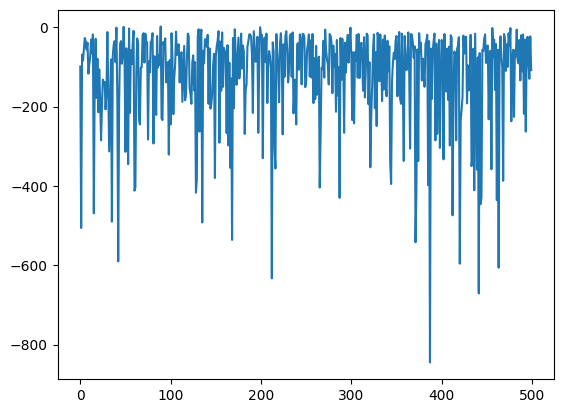

In [54]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

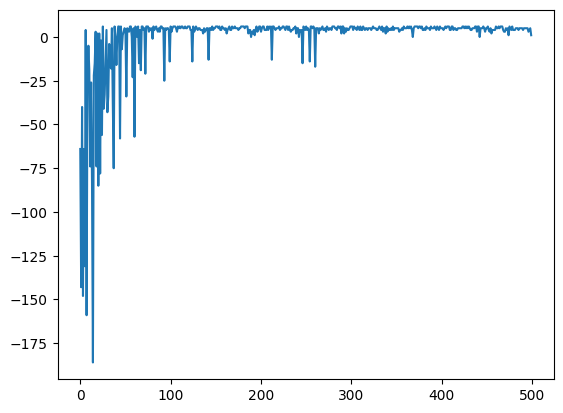

In [55]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [56]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.31889999999999996
	LEFT
		-0.4
	RIGHT
		-0.28432742401
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		4.694861135326071
(0, 2)
	UP
		3.622783359270359
	DOWN
		2.7308892279717627
	LEFT
		0.8196754536701797
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.8999550180377525
	DOWN
		0
	LEFT
		9.999595162339771
	RIGHT
		0.11247797953261754
(0, 5)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		3.752649081250378
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.31000000000000005
	LEFT
		0.0012001380496558522
	RIGHT
		-0.30000000000000004
(0, 7)
	UP
		-0.4
	DOWN
		-0.3919
	LEFT
		-0.47606762
	RIGHT
		-0.49000000000000005
(1, 0)
	UP
		-0.547339
	DOWN
		-0.569231259
	LEFT
		-0.5
	RIGHT
		-0.4763900000000001
(1, 1)
	UP
		-0.35371
	DOWN
		-0.339838
	LEFT
		-0.31000000000000005
	RIGHT
		4.196769607014481
(1, 2)
	UP
		8.999999999999986
	DOWN
		3.5992565123316203
	LEFT
		0.6635741467148628
	RIGHT
		-5.6953279000000006
(1, 3)
	UP
		0
	